# Clasificación de imágenes usando "resnet18"

En este proyecto, exploraremos el proceso de creación de un modelo sencillo de clasificación de imágenes utilizando técnicas de aprendizaje profundo. El objetivo es desarrollar un sistema capaz de determinar si una imagen dada contiene un pájaro o no.

In [1]:
# Librerías
from duckduckgo_search import DDGS  
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
import time, json

### Buscamos la imágenes

La función *search_images* realiza la búsqueda de imágenes en Internet usando la API de DuckDuckGo.

In [2]:
def search_images(keywords : str, max_images : int = 200 ) -> L: 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [3]:
# Realizamos una prueba
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

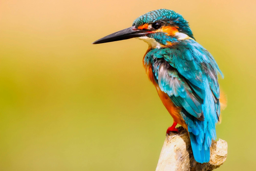

In [4]:
# Hechamos un vistazo a la imagen.

dest = 'bird.jpg' # La guardamos en el directorio actual
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

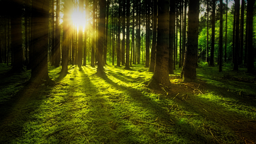

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Definimos una ruta base donde se guardarán las imágenes. Luego, descargamos imágenes relacionadas con las palabras clave "forest" y "bird", y las redimensionamos a un tamaño máximo de 400 píxeles.

In [7]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_image(path/o, max_size=400, dest=path/o)

In [8]:
# Algunas fotos no se descargan correctamente, por lo tanto debemos eliminarlas para entrenar el modelo.
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

13

**DataBlock** es una clase de Fastai que permite definir cómo se deben cargar y transformar los datos para entrenar un modelo. Lo usaremos para trabajar con las imágenes y sus etiquetas de categoría :) 

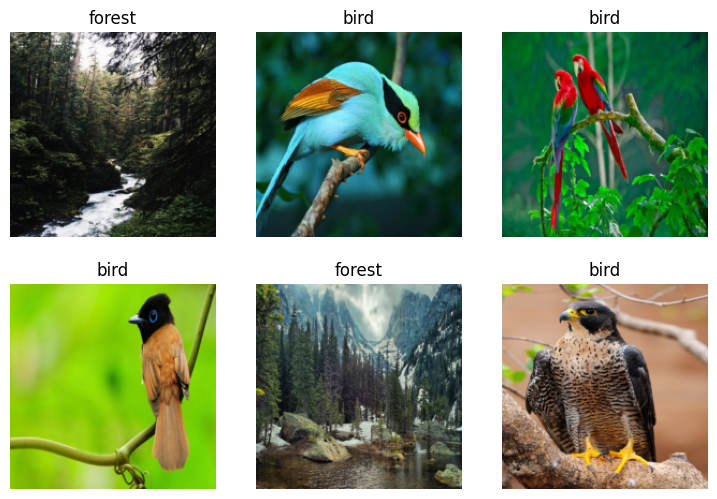

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Indicamos de que tipo será cada bloque
    get_items=get_image_files,          # Recorre un directorio y obtiene la lista de rutas de las imágenes
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Dividimos los datos de manera aleatorio, 20% de los datos para validación y ponemos la semilla de .
    get_y=parent_label,                 # Obtiene el nombre de la carpeta padre de cada imagen
    item_tfms=[Resize(192, method='squish')] # Redimencionamos las imagenes
).dataloaders(path , bs=32)             # Generamos un objeto dataloaders que será usado para cargar los datos en el entrenamiento. 

dls.show_batch(max_n=6)

Para crear y entrenar este modelo usamos una red neuronal convolucional preentrenada ( ResNet-18 ). Esto permite su uso en **transfer learning** ( aprendisaje por transferencia ), lo que se traduce en un menor uso de datos y tiempo de entrenamiento.

Una característica clave es el uso de **Bloques Residuales**, que es la ventaja principal de ResNet. Estos bloques permiten que la red aprenda las diferencias entre la información de entrada respecto a la informacion de salida. Esto se logra con algo llamado *skip connections* ( conexiones de salto ) que permite que la información fluya directamente a través de la red sin pasar por ciertas capas, esto nos facilita el entrenamiento.

Luego, realizamos un *fine-tunning* ( ajuste fino ) del modelo, entrenandolo durante 3 épocas ( pases completos sobre los datos de entrenamiento )

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.558598,0.394968,0.068493,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.032305,0.026641,0.013699,00:37
1,0.017187,0.005850,0.000000,00:36
2,0.014360,0.003278,0.000000,00:36


In [14]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Recalcamos que ResNet-18 es un modelo preentrenado en ImageNet, un conjunto de datos muy grande y ampliamente utilizado en visión por computadora. Por eso, el uso de **fine-tuning** (ajuste fino) es clave, ya que permite ajustar los pesos (los parámetros internos de la red neuronal que se optimizan durante el entrenamiento) para que el modelo se adapte a un conjunto de datos específico.

Para conservar el conocimiento adquirido durante el preentrenamiento, el fine-tuning ajusta principalmente las capas finales del modelo, mientras que las capas iniciales suelen congelarse. Esto evita perder las características generales que el modelo ya sabe detectar (bordes, texturas y formas) y permite que se especialice en las características específicas del nuevo conjunto de datos.